In [2]:
import sys 
import os 
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sys.path.append('../')
import glob
import tqdm

In [3]:
from src.utils.normalizer import Normalizer

In [25]:
def calculate_explained_variance(importances):
    """calculate the explained variance of the importances along the columns and rows"""
    
    explained_variance_columns = torch.var(importances, dim=0) / torch.var(importances)
    explained_variance_rows = torch.var(importances, dim=1) / torch.var(importances)
    
    return explained_variance_columns, explained_variance_rows

In [ ]:
# linear_layer = "layer_1/mlp.up_proj"

layers = glob.glob(f"/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/original_weights/*/*.pt")

device = torch.device("cuda:7")
explained_variance_rows = []
explained_variance_columns = []
with torch.no_grad():
    for linear_layer in tqdm.tqdm(layers):
        weight = torch.load(linear_layer, map_location=device)["weight"]
        hessian_diag = torch.load(linear_layer.replace("original_weights", "hessianDiags/seed_0/pajama/128"), map_location=device)
        # print(hessian_diag.keys())
        hessian_diag = hessian_diag["hessianDiag"]
        
        importances = torch.log(torch.abs(weight) * hessian_diag.unsqueeze(0)).to(torch.float32)
        # print(importances)
        # raise ValueError
        explained_variance_column, explained_variance_row = calculate_explained_variance(importances)
        explained_variance_columns.append(explained_variance_column.cpu().numpy())
        explained_variance_rows.append(explained_variance_row.cpu().numpy())

100%|██████████| 224/224 [00:11<00:00, 20.19it/s]


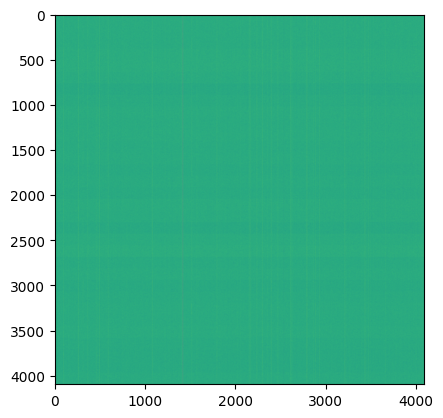

In [40]:
plt.imshow(importances.cpu().numpy())

In [33]:
explained_variance_rows = np.concatenate(explained_variance_rows, axis=0)
explained_variance_columns = np.concatenate(explained_variance_columns, axis=0)

In [36]:
np.nanmax(explained_variance_rows)

/tmp/ipykernel_740197/1971729870.py:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(explained_variance_rows)


np.float32(nan)

In [37]:
np.nanmax(explained_variance_columns)

/tmp/ipykernel_740197/2070651947.py:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(explained_variance_columns)


np.float32(nan)

In [222]:
linear_layer = "layer_0/self_attn.k_proj"
with torch.no_grad():
    linear_layer = f"/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/original_weights/{linear_layer}.pt"
    device = torch.device("cuda:7")
    weight = torch.load(linear_layer, map_location=device)["weight"].to(torch.float32)
    hessian_diag = torch.load(linear_layer.replace("original_weights", "hessianDiags/seed_0/pajama/128"), map_location=device)
    # print(hessian_diag.keys())
    hessian_diag = hessian_diag["hessianDiag"]
    
    _,weight_normalized = Normalizer.normalize_init(weight, [0,1], [False,False],norm_rescale=True, powers=1,
                                                        p=2)

    importances = torch.abs(weight) * hessian_diag.unsqueeze(0)
    
    importances_normalized = torch.abs(weight_normalized) * hessian_diag.unsqueeze(0)

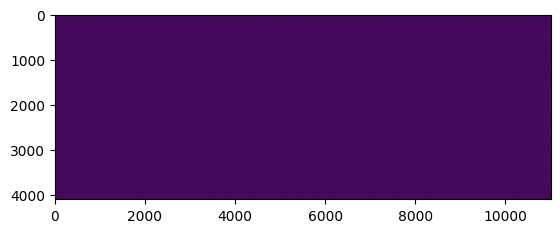

In [203]:
# weight_plot = torch.abs(weight)
# weight_plot = torch.clip(weight_plot, 0,torch.quantile(weight_plot, 0.99))
# # print(weight_plot)
plt.imshow(weight_plot.cpu().numpy()) 

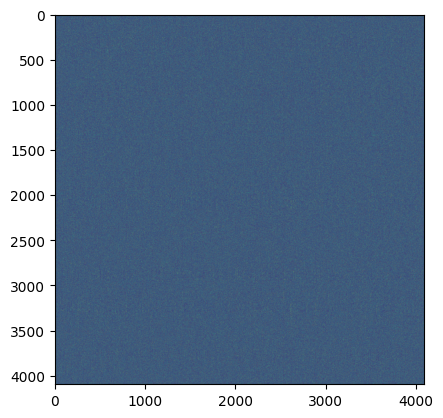

In [212]:
weight_normalized_plot = torch.abs(weight_normalized)
weight_normalized_plot = torch.clip(weight_normalized_plot, 0,torch.quantile(weight_normalized_plot, 0.99))
plt.imshow(weight_normalized_plot.cpu().numpy()) 


In [223]:
#remove the lower 50% of the importances
frac_to_remove = 0.5
print(np.percentile(importances.to(torch.float32).cpu().numpy(), frac_to_remove))
mask = importances.to(torch.float32) > np.percentile(importances.to(torch.float32).cpu().numpy().flatten(), frac_to_remove*100)
mask_normalized = importances_normalized.to(torch.float32) > np.percentile(importances_normalized.to(torch.float32).cpu().numpy().flatten(), frac_to_remove*100)


0.0


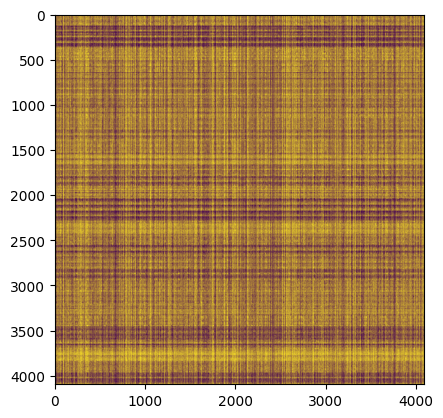

In [224]:
plt.imshow(mask.cpu().numpy())

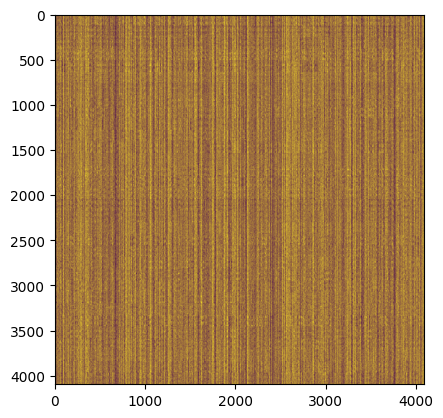

In [225]:
plt.imshow(mask_normalized.cpu().numpy())

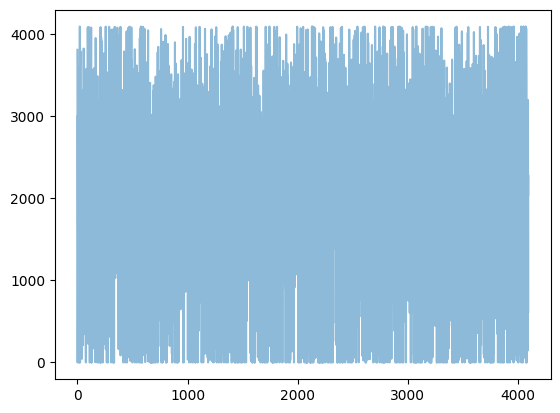

In [226]:
plt.plot(np.arange(4096), mask_normalized.sum(dim=0).cpu().numpy(),alpha=0.5)

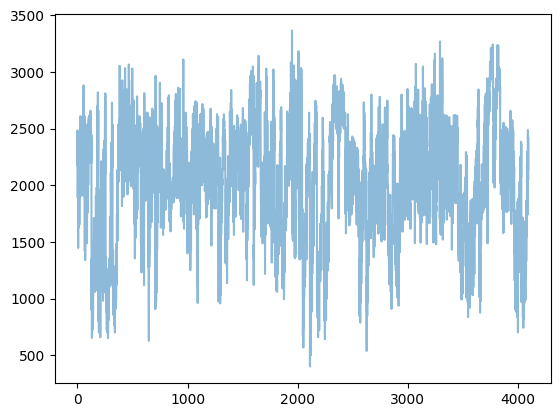

In [227]:
plt.plot(np.arange(4096), mask.sum(dim=1).cpu().numpy(),alpha=0.5)

(array([7.20263672, 1.08764648, 1.03930664, 0.65258789, 0.38671875,
        0.53173828, 0.53173828, 0.45922852, 0.65258789, 0.53173828,
        0.67675781, 0.36254883, 0.79760742, 0.50756836, 0.72509766,
        0.62841797, 0.5559082 , 0.45922852, 0.5559082 , 0.67675781,
        0.43505859, 0.74926758, 0.5559082 , 0.62841797, 0.74926758,
        0.72509766, 0.60424805, 0.91845703, 0.87011719, 0.7734375 ,
        1.03930664, 0.82177734, 0.67675781, 0.91845703, 0.94262695,
        1.06347656, 0.79760742, 0.9909668 , 1.01513672, 0.79760742,
        0.96679687, 0.9909668 , 0.84594727, 0.91845703, 1.16015625,
        1.03930664, 1.01513672, 1.18432617, 1.28100586, 1.16015625,
        1.13598633, 1.16015625, 1.28100586, 1.06347656, 1.3293457 ,
        1.47436523, 1.3293457 , 1.3293457 , 1.47436523, 1.546875  ,
        1.45019531, 1.16015625, 1.3293457 , 1.546875  , 1.11181641,
        1.25683594, 1.16015625, 1.20849609, 1.52270508, 1.28100586,
        1.52270508, 1.546875  , 1.47436523, 1.35

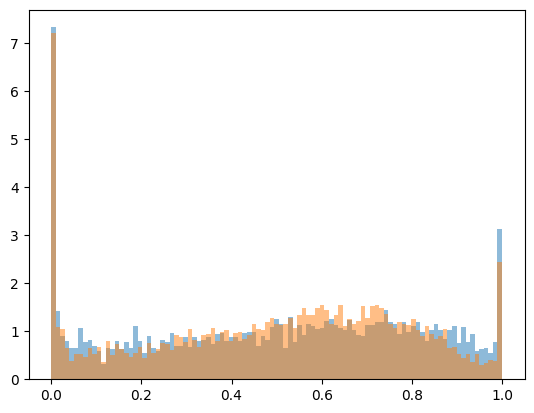

In [229]:
bins = np.linspace(0,1,100)
plt.hist(torch.sum(mask,dim=0).cpu().numpy()/mask.shape[0], bins=bins, density=True, alpha=0.5)

plt.hist(torch.sum(mask_normalized,dim=0).cpu().numpy()/mask_normalized.shape[0], bins=bins, density=True, alpha=0.5)

# plt.yscale("log")

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.41699219e-02, 2.41699219e-02,
        0.00000000e+00, 4.83398437e-02, 7.25097656e-02, 4.83398437e-02,
        2.41699219e-02, 4.83398438e-02, 9.66796875e-02, 1.69189453e-01,
        3.86718750e-01, 8.21777344e-01, 2.46533203e+00, 6.62255859e+00,
        1.91184082e+01, 3.32819824e+01, 2.59343262e+01, 6.91259766e+00,
        1.57104492e+00, 8.45947266e-01, 2.41699219e-01, 2.175292

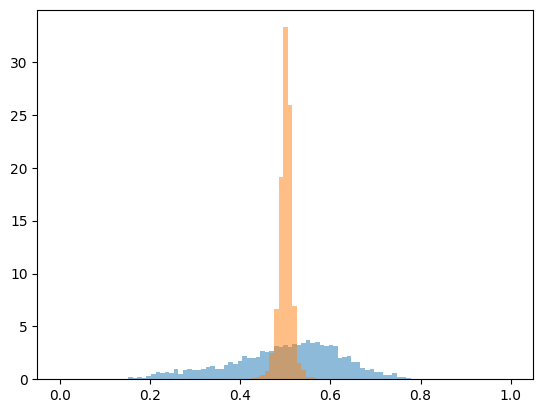

In [230]:
bins = np.linspace(0,1,100)
plt.hist(torch.sum(mask,dim=1).cpu().numpy()/mask.shape[0], bins=bins, density=True, alpha=0.5)

plt.hist(torch.sum(mask_normalized,dim=1).cpu().numpy()/mask_normalized.shape[0], bins=bins, density=True, alpha=0.5)
